<a href="https://colab.research.google.com/github/premonish/YOUNGER/blob/main/YOUNGER_Age_Estimator_WRANGLING_EDA_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **YOUNGER - Age Estimator**

# **I. PROBLEM IDENTIFICATION**

## A. Introduction

**CONTEXT:** "Babyface" a startup skincare company wants to build an app that can estimate a person’s age from an image. They need an app to create an age estimate within about 5 years of their real age. The primary problem to solve is: When given a photo of a face, estimate the age with reasonable accuracy. Babyface will eventually use this to create "before & after" age estimates to demonstrate the benefits of their skin products.

**[INPUT] → [OUTPUT]**

**[Photo of a face] → [Age estimate]**

## B. Proposed Method

**i. The techniques** to explore are a combination of **Support Vector Machines, Decision Trees, K Nearest Neighbor, and Convolutional Neural Network (CNN)** (for feature detection).

**ii. Process Overview**

1. DATA WRANGLING - Source Data, Download Data, Inspect Data, Clean Data
2. EXPLORATORY DATA ANALYSIS - Statistical EDA, Visual EDA
3. PREPROCESSING - Face Detection, Crop Images, Augmentation, Class Balancing
4. TRAINING - Feature Extraction
5. MODELING - Prediction, Hyperparameter Tuning

# **II. DATA WRANGLING**

**DATASET:** Researchers from ETH Zurich University have created a labeled dataset used to successfully predicting age and gender from face images.
The image dataset consists of human faces with associated ages. 

"In total we obtained 460,723 face images from 20,284 celebrities from IMDb and 62,328 from Wikipedia, thus 523,051 in total."

[IMDB-WIKI – 500k+ face images with age and gender labels
Rasmus Rothe, Radu Timofte, Luc Van Gool](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/)


**DETAILS:** The dataset that we will use for our age predictor was created by Rasmus Rothe, Radu Timofte, Luc Van Gool in combination with a competition "ChaLearn LAP 2015" dataset. This dataset was scraped from IMDb and Wikipedia. The dataset is labeled with date-of-birth (DOB) and gender and includes only images with timestamps, indicating when the image was captured. The age of the person in the image can be obtained by simply subtracting the person's date of birth from the timestamp (picture taken date). It is important to note that some of the IMDb dataset images are "production photos" like movie posters and the timestamps may not be precise, since movie production cycles can be months long.

**APPROACH:** *Source, Download, Inspect, Clean:* Since we have sourced an image dataset, we will proceed by downloading the dataset and exploring the images and metadata to understand the attirbutes of the data and any constraints or missing information. The ages can be calculated from the subjects' date of birth and the related photo taken date. We will then clean our dataset as needed and distill the dataset down to the essential features useful for feature extraction.

In [1]:
# !pip install tensorflow

**Why Google Colab?**

Google Colab was chosen as we intend to use a deep learning convolutional neural network (CNN) for training and modeling as CNNs excel for image classification projects. Google Colab provides free access to GPUs that will expedite training immensely. The platform is also very handy for live team collaboration in a Google Docs/Sheets style.

In [2]:
# Creating a list of currently installed python libraries for posterity
# !pip freeze > requirements.txt

In [3]:
### IMPORT libraries and packages ###
### I get by with a little help from my friends ###
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
import requests
import scipy.io
import random
from datetime import datetime, date, time, timedelta

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input

**COLAB/ Google Drive**

We have uploaded our dataset to Google Drive for easy access in the Google Colab environment. To access Google Drive, we must mount the drive.

In [4]:
# mount GDrive where the dataset is stored
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


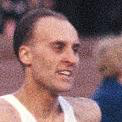

In [5]:
### VIEW A RANDOM IMAGE FROM DATASET ###
# loc = 'C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/wiki_crop_subset/81800_1986-06-13_2011.jpg'
directory = '/content/drive/MyDrive/YOUNGER/wiki_crop/01'
dir_list = []
for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        dir_list.append(os.path.join(directory, filename))

random_number = random.randint(0,len(dir_list))
random_image = Image.open(dir_list[random_number]) 
random_image

**Metadata Inspection** 

Next, we will inspect the metadata to understand the dataset. We will focus on the Wikipedia dataset.

In [6]:
### LOAD METADATA FILE ###
# wiki_mat_path = 'C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/WIKI_CROP/wiki.mat'
wiki_mat_path = '/content/drive/MyDrive/YOUNGER/wiki.mat' # COLAB

# load .mat as python dict
mat = scipy.io.loadmat(wiki_mat_path)

# Metadata Keys #
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'wiki'])


In [7]:
### INSPECT METADATA STRUCTURE ###
print(mat['wiki'][0][0])

(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
        array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
        array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
        array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
        array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
        array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
      dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
        array(['Dettmar Cramer'], dtype='<U14'),
        array(['Marc Okrand'], dtype='<U11'), ...,
        array(['Michael Wiesinger'], dtype='<U17'),
        array(['Johann Grugger'], dtype='<U14'),
        array(['Greta Van Susteren'], dtype='<U18')]], dtype=object), array([[array([[111.29109473, 111.29109473, 252.66993082, 252.66993082]]),
  

**MATLAB to pandas DataFrame**

Next, we will transform the data from the '.mat' MATLAB nested structure into an easier-to-read pandas DataFrame with a familiar table format.


In [8]:
### CREATE DATAFRAME FROM METADATA ###
# Assign the length of the array to 'num_of_observations'
num_of_observations = mat['wiki'][0][0][0].shape[1]
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

# Create pandas dataframe as tall as 'num_of_observations' with column headers from metadata
df = pd.DataFrame(index = range(0, num_of_observations), columns = columns)

# Iterate through the 'wiki' header of the metadata
for i in mat:
  if i == "wiki":
    wiki_array = mat[i][0][0]               # Dig two layers deep into the dict structure and assign to 'wiki_array'
    for b in range(len(wiki_array)):        
      df[columns[b]] = pd.DataFrame(wiki_array[b][0]) # Create a pandas DataFrame for each nested value and assign to respective df[columns]

df.sample(5)

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
60387,711628,2007,[96/26951296_1948-05-15_2007.jpg],1.0,[Rajan Gurukkal],"[[96.3717031357533, 125.77838102367738, 161.73...",2.033092,NaN
35268,705893,1980,[33/755133_1932-09-01_1980.jpg],0.0,[Sunny von Bülow],"[[1, 1, 1, 1]]",-inf,NaN
8717,702695,1956,[20/43118620_1923-11-30_1956.jpg],0.0,[Lourdinha Bittencourt],"[[377.77887190029304, 164.72194430447524, 440....",0.897401,0.820841
36386,722185,2004,[76/37573676_1977-04-10_2004.jpg],1.0,[Oded Sharon],"[[41.756100961393656, 165.2244038455746, 226.3...",3.198308,NaN
22749,715264,2012,[51/3631151_1958-04-29_2012.jpg],0.0,[Eve Plumb],"[[160.1770156657054, 100.44063479106588, 338.5...",4.619890,NaN


**Metadata Feature Descriptions**

---

**dob:** date of birth (Matlab serial date number)

**photo_taken:** year when the photo was taken

**full_path:** path to image file in folder

**gender:** 0 = female, 1 = male, NaN = unknown

**name:** full name 

***face_location:** location of the face 

***face_score:** detector score ('inf'= no face detected)

***second_face_score:** detector score of the face with the second highest score. 'NaN' if no second face was detected.

---

(*)  Features created during preprocessing indicated with asterisk *

**Metadata Preprocessed Features**

Some features have been inherited from the preprocessing of the dataset. Namely, these preprocessed features are: face_location, face_score, and second_face_score. The features were created with a face detection algorithm ([Mathias et al. 2014](https://https://www.researchgate.net/publication/265125544_Face_Detection_without_Bells_and_Whistles)) and contain the relative position of the face, how strongly a face was detected in the image and how strongly a second face was detected, respectively. 

In [9]:
### INSPECT DATAFRAME ###
print("***There are", df.shape[0], "images and", df.shape[1], "features in this dataset.***")
print(" ")
print(df.info())

***There are 62328 images and 8 features in this dataset.***
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dob                62328 non-null  int32  
 1   photo_taken        62328 non-null  uint16 
 2   full_path          62328 non-null  object 
 3   gender             59685 non-null  float64
 4   name               62328 non-null  object 
 5   face_location      62328 non-null  object 
 6   face_score         62328 non-null  float64
 7   second_face_score  4096 non-null   float64
dtypes: float64(3), int32(1), object(3), uint16(1)
memory usage: 3.2+ MB
None


**Observations**

1. 'gender' column has missing values. 
2. 'second_face_score' has spare data and mostly Null values. 

In [10]:
print("General information about the dataset: ")
print("======================================")
print("Oldest Photo Date: "+str(df.photo_taken.min()))
print("Most Recent Photo Date: "+str(df.photo_taken.max()))
print("Minimum Face Score: "+str(df.face_score.min()))
print("Maximum Face Score: "+str(round(df.face_score.max(),3)))
print("Null Second Face Scores: "+ str(df.second_face_score.isna().sum()))

General information about the dataset: 
Oldest Photo Date: 1940
Most Recent Photo Date: 2015
Minimum Face Score: -inf
Maximum Face Score: 7.081
Null Second Face Scores: 58232


We need to convert "dob" from Matlab datenum into Python datetime and then compute each subject's age.

In [11]:
# Function to convert Matlab datenum into Python datetime
def datenum_to_datetime(datenum):
  days = datenum % 1
  hours = days % 1 * 24
  minutes = hours % 1 * 60
  seconds = minutes % 1 * 60
  exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)
  return exact_date.year
 
# Convert Matlab datenum into Python datetime & create a new columns 'date_of_birth'
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

# Compute age by subtracting 'date_of_birth' from 'photo_taken'
df['age'] = df['photo_taken'] - df['date_of_birth']
df['age'].sample(5)

19778    29
46425    24
15360    24
4773     19
49881    30
Name: age, dtype: int64

In [12]:
# Check the maximum & minimum age...
print('age.max', str(df.age.max()))
print('age.min', str(df.age.min()))

age.max 1996
age.min -74


We can see that there are some ages that are impossible. Let's clean up the dataset by removing observations that are over 100 and under 0. 

In [13]:
# Remove ages over 100 & remove ages under 0
df_shape_raw = df.shape[0]
df = df[df['age'] <= 100]
df = df[df['age'] > 0]

diff = df_shape_raw - df.shape[0]
print('We cleaned', df_shape_raw - df.shape[0], 'observations or',round((diff/df_shape_raw*100),2),'percent of the Wikipedia Dataset that were out of the age range 0-100.')

We cleaned 1880 observations or 3.02 percent of the Wikipedia Dataset that were out of the age range 0-100.


**DATA CLEANING**

We will clean by omitting data with missing gender information, images where faces were not detected (represented by -inf), images where a second face *is* detected, and images that have a face detection score (face_score) of less than '3.0'.

In [14]:
### CLEAN THE DATASET ###

# Remove records with missing gender data
df = df[~df['gender'].isna()]

# Remove images where faces were not detected
df = df[df['face_score'] != -np.inf]
 
# Include only images with a second face score missing (NaN)
# We don't want to deal with extra faces in the images
df = df[df['second_face_score'].isna()]
 
# Include images that have a primary 'face_score' of 3 or more
df = df[df['face_score'] >= 3.0]

**Columns to Drop**

'name' are arbitrary, so we will drop the names.

'dob' has been replaced by date_of_birth.

'second_face_score' are all "Nan". Let's drop them.

In [15]:
# Drop columns that won't inform the prediction model
df = df.drop(columns = ['dob','name', 'second_face_score'])

# **III. EXPLORATORY DATA ANALYSIS**

## **METADATA**
**Distribution Visualizations**

Let's take a look at the shape of the dataset's variables with some colorful histograms.

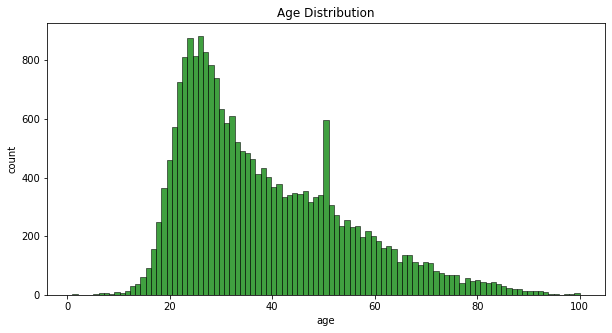

In [16]:
# Plot Age Distribution represented in the dataset
plt.figure(figsize=(10, 5))
# histogram_age = df['age'].hist(bins=df['age'].nunique())
sns.histplot(df['age'], bins=df['age'].nunique(), color='green')
plt.title('Age Distribution')
plt.xlabel('age')
plt.ylabel('count');

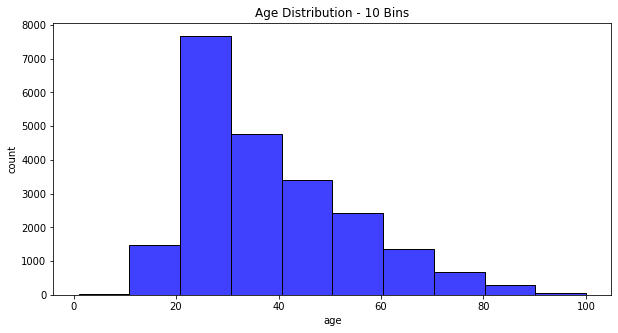

In [17]:
# Plot Age Distribution in ten (10) age bins
plt.figure(figsize=(10, 5))
# histogram_age = df['age'].hist(bins=10)
sns.histplot(df['age'],bins=10, color='blue')
plt.title('Age Distribution - 10 Bins')
plt.xlabel('age')
plt.ylabel('count');

The Age Distribution is **right skewed** with a large representation in the 20-30 age range. We must consider balancing the classes before training our algorithm as a biased dataset would lead to a biased output (age estimation). 

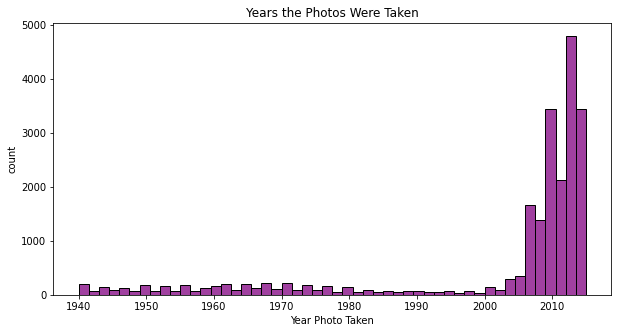

In [18]:
# Plot Years Photos Taken Distribution represented in the dataset
plt.figure(figsize=(10, 5))
sns.histplot(df['photo_taken'], bins=50, color='purple')
# histogram_age = df['face_score'].hist(bins=50)
plt.title('Years the Photos Were Taken')
plt.xlabel('Year Photo Taken')
plt.ylabel('count');

As we might expect, most of the images in the dataset were created in the last 20 years, coinciding with the boom of digital imagery and the explosion of digital data creation.

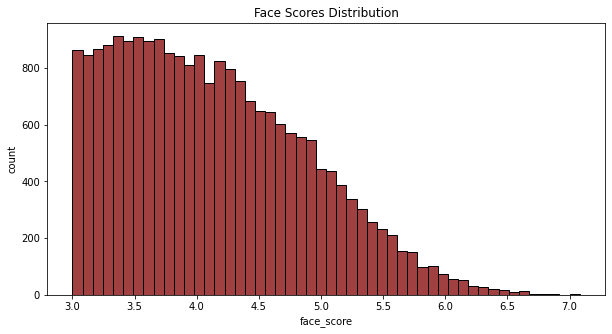

In [19]:
# Plot face_score Distribution represented in the dataset
plt.figure(figsize=(10, 5))
sns.histplot(df['face_score'], bins=50, color='maroon')
# histogram_age = df['face_score'].hist(bins=50)
plt.title('Face Scores Distribution')
plt.xlabel('face_score')
plt.ylabel('count');

The Face Scores distribution shows that we subset for images with a face scores of 3 or above. This will ensure that we are working with faces that were clearly detected during
 preprocessing.

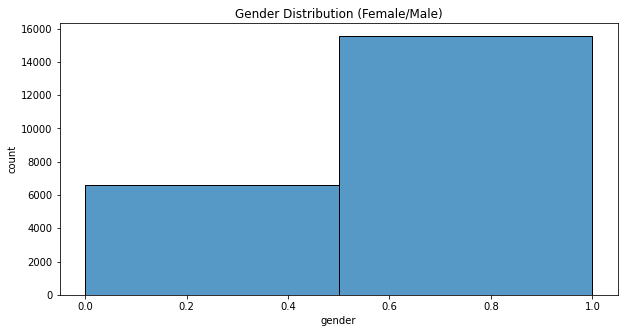

In [20]:
# Plot Gender Distribution represented in the dataset
plt.figure(figsize=(10, 5))
sns.histplot(df['gender'], bins=2)
# histogram_age = df['gender'].hist(bins=2)
plt.title('Gender Distribution (Female/Male)')
plt.xlabel('gender')
plt.ylabel('count');

The left side of the plot represents 'female' and the right side of the plot represents 'male'. The gender distribution is very uneven with many more 'male' subjects represented. We will consider balancing this as well.

In [21]:
### Descriptive Statistics about Age Distribution ###
df.age.describe()

count    22138.000000
mean        38.210678
std         15.871291
min          1.000000
25%         26.000000
50%         34.000000
75%         48.000000
max        100.000000
Name: age, dtype: float64

## **IMAGES**
Let's prepare the images directly.

##**Images ---> Pixel Values ---> Vectors**

We need to convert the images from pixels to vectors. Specifically, we need to convert the images from colored, 3-channel pixels to long one-dimensional vectors.  This is required to hunt for patterns, reduce complexity, and extract features.

Each digital image is composed of a large grid of pixels. In color images, each pixel has 3 color channels: Red, Green, Blue (RGB). Each color channel's intensity are in the range [0-255]. 

To translate our images from photos (jpg format) to vectors of pixel values, we will first use a *Keras module called "load_img" to read the images in a PIL (Python Imaging Library) format. We will set the 'color mode' argument to (RGB) and set the target-size to 224 x 224 pixels. 

Next, we will use Kera's "img_to_array" module to extract the pixel information and store it in an array (index-based vector) of 150,528 numbers per image (224x224x3). 

*Keras is a high-level API interface for TensorFlow for working with artificial neural networks (ANN). TensorFlow & Keras are frequently used on computer vision image classification projects, such as this.

*Prem: I remember being inspired to learn more about AI when hearing VC Marc Andreessen talk about how acccessible TensorFlow was in a 2018 [Tim Ferriss Show podcast](https://https://tim.blog/2018/01/01/the-tim-ferriss-show-transcripts-marc-andreessen/). He said "So all of a sudden, AI is like a tractable thing that you can just have on your own laptop, and you can build new things on top of it."*

In [22]:
# Create function to load images using 'load_img' and create 1 array per image (224, 224, 3)
target_size=(224, 224)

def getImagePixels(image_path):
    # img = image.load_img("C:/Users/Prem/Desktop/SPRINGBOARD_MASTER/YOUNGER/Data/wiki_crop/%s" % image_path[0], grayscale=False, target_size=(224, 224))
    img = image.load_img("/content/drive/MyDrive/YOUNGER/wiki_crop/%s" % image_path[0], color_mode='grayscale', target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    # x = preprocess_input(x)
    return x

**Images to Grayscale?**

We reduce the images to grayscale to reduce the heavy load of data per image (by a factor of three). Also, image classification on color images is more prone to overfitting. Color images are much more compute and memory intensive compared to grayscale images.

In [23]:
### SUBSETTING THE DATASET FOR RAPID TESTING ### ### TESTING ### ### TESTING ### ### TESTING ###
# df = df[:2000]
### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### ### TESTING ### 

In [24]:
%%time
# apply 'getImagePixels' function to all observations and create new column df.pixels
df['pixels'] = df['full_path'].apply(getImagePixels)

CPU times: user 4.43 s, sys: 1.03 s, total: 5.46 s
Wall time: 1min 59s


In [26]:
# reset index for clarity
df = df.reset_index()    

In [27]:
# Convert pandas Series Object into a numpy array
pix_np = df['pixels'].to_numpy(dtype=None, copy=False)

**We will export the vector of image data as a compressed Numpy array object.**

In [ ]:
from numpy import asarray, savez_compressed, load
# save a compressed numpy object
savez_compressed('data1.npz', pix_np)

In [ ]:
# from numpy import asarray, savez_compressed, load
# load dict of arrays
matrix_x = np.load('/content/drive/MyDrive/YOUNGER/data1.npz', allow_pickle=True)
matrix_x = images.f.arr_0

In [28]:
# convert df.ages to numpy array, assign to 'vector_y'
vector_y = df.age.to_numpy(dtype=None, copy=False)

**NOTE: The numpy array of the image data is 2.53 GB compressed. **

**This is a logical break point in the process as we have exported matrix_x, the array of pixel data and the related target vector, age.**

'matrix_x' is the array of the vectors of image pixel data.

'vector_x' is the array of ages.

---

## **IMAGE EXPLORATION**

---

##**"Average Face" Image**

It is interesting to think about the concept of an "average face". What would that look like? Well, since we already have our face image dataset, we can aggregate the mean (average) of the arrays of each image and create "average face" images with different subset sizes. Let's try this with 2, 5, 20, 100, and 1,000 face images for fun.

*Aside*: The National Geographic [created an image](https://https://www.cbsnews.com/news/meeting-earths-most-typical-person/) from 190,000 overlayed images to create an 'everyman' concept image. 

In [29]:
# image averaging function (with titles)
def find_mean_img(full_mat, title, size=(224,224,3)):
    mean_img = np.mean(full_mat, axis=0)
    mean_img = mean_img.reshape(size)
    mean_img = mean_img/255
    plt.imshow(mean_img)
    plt.title(f'Average of {title} images')
    plt.axis('off')
    plt.show()
    return mean_img

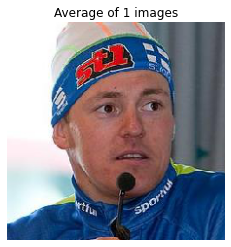

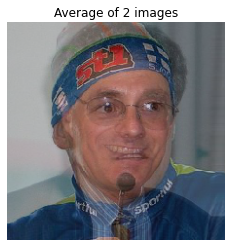

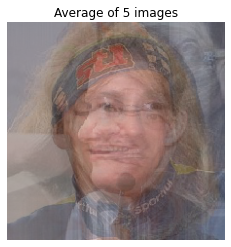

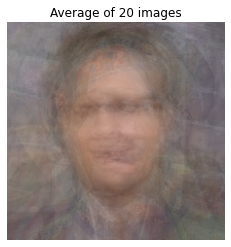

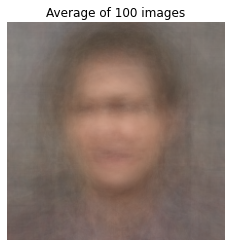

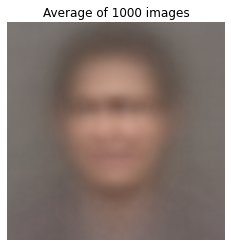

In [34]:
im1 = find_mean_img(df['pixels'][0:1], '1')
im2 = find_mean_img(df['pixels'][:2], '2')
im5 = find_mean_img(df['pixels'][:5], '5')
im20 = find_mean_img(df['pixels'][:20], '20')
im100 = find_mean_img(df['pixels'][:100], '100')
im1000 = find_mean_img(df['pixels'][:1000], '1000')
# im2000 = find_mean_img(df['pixels'][1000:2000], '1000 (2)')
# im3000 = find_mean_img(df['pixels'][2000:3000], '1000 (3)')
# im4000 = find_mean_img(df['pixels'][3000:4000], '1000 (4)')

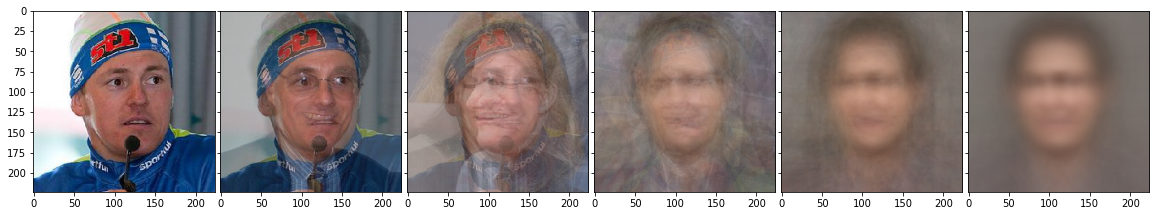

In [33]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(1, 6),  # creates 2x2 grid of axes
                 axes_pad=0.08,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im5, im20, im100, im1000]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

###**"Average Face" Observation**

The images seem to converge into a regular average 'face' with a distinguishable head shape, a horizontal darker band where eyes would be and some vague nose and mouth features. It is important to note that the preprocessed dataset have been cropped to align faces in the center with approximately the same space around the head. Let's take a look at an average female face compared to an average male face.


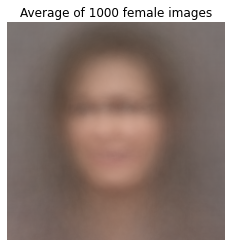

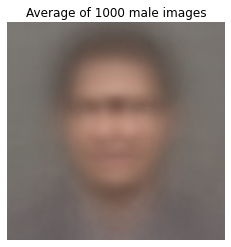

In [35]:
# Subset by gender to find Average Male & Average Female face 
# subset for genders
df_gender0 = df['gender'] == 0
df_gender1 = df['gender'] == 1
df0 = df[df_gender0]     # gender 0 female dataframe for visualization
df1 = df[~df_gender0]    # gender 1 male dataframe for visualization
all_mean4000 = find_mean_img(df0['pixels'][:1000], '1000 female')
all_mean4000 = find_mean_img(df1['pixels'][:1000], '1000 male')

Despite being seemingly blurry, I percieve a distinct gender difference between the two composite images.

In [36]:
# AGE GROUPS: 0-3, 0-5, 0-10, 10-19, 20-29, 30-39, 40-49, 50-59, 60-69,  70-79, 80-89, 90-100    
# SUBSET INTO AGE GROUPS
age_0_to_3     =  (df.age >  0 ) & (df.age <= 3)
age_0_to_5     =  (df.age >  0 ) & (df.age <= 5)
age_0_to_10    =  (df.age >  0 ) & (df.age <= 10)
age_10_to_19   =  (df.age >= 10) & (df.age <  20) 
age_20_to_29   =  (df.age >= 20) & (df.age <  30)
age_30_to_39   =  (df.age >= 30) & (df.age <  40)
age_40_to_49   =  (df.age >= 40) & (df.age <  50)
age_50_to_59   =  (df.age >= 50) & (df.age <  60)
age_60_to_69   =  (df.age >= 60) & (df.age <  70)
age_70_to_79   =  (df.age >= 70) & (df.age <  80)
age_80_to_89   =  (df.age >= 80) & (df.age <  90)
age_90_to_100  =  (df.age >= 90) & (df.age <= 100)

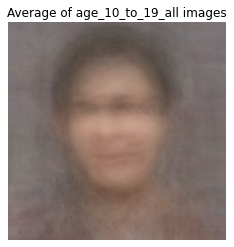

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


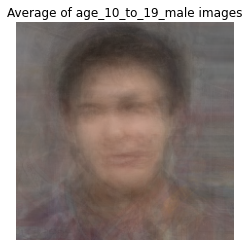

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


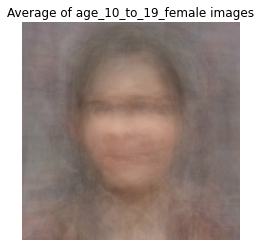

In [37]:
age_10_to_19_all = find_mean_img(df[age_10_to_19]['pixels'], "age_10_to_19_all")
age_10_to_19_male = find_mean_img(df1[age_10_to_19]['pixels'], "age_10_to_19_male")
age_10_to_19_female = find_mean_img(df0[age_10_to_19]['pixels'], "age_10_to_19_female")

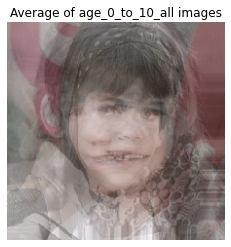

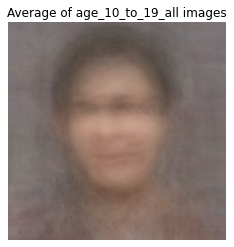

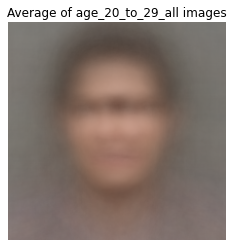

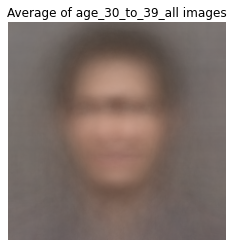

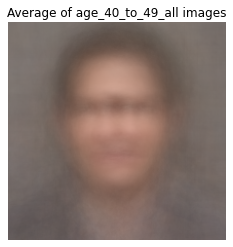

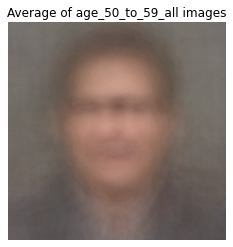

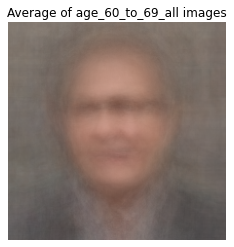

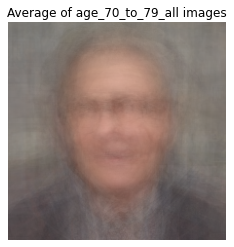

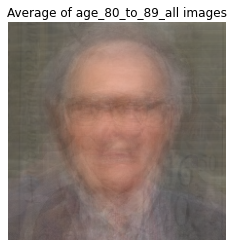

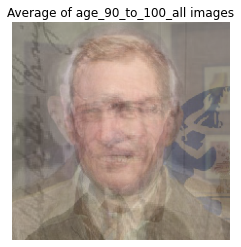

In [38]:
age_0_to_10_all = find_mean_img(df[age_0_to_10]['pixels'], "age_0_to_10_all")
age_10_to_19_all = find_mean_img(df[age_10_to_19]['pixels'], "age_10_to_19_all")
age_20_to_29_all = find_mean_img(df[age_20_to_29]['pixels'], "age_20_to_29_all")
age_30_to_39_all = find_mean_img(df[age_30_to_39]['pixels'], "age_30_to_39_all")
age_40_to_49_all = find_mean_img(df[age_40_to_49]['pixels'], "age_40_to_49_all")
age_50_to_59_all = find_mean_img(df[age_50_to_59]['pixels'], "age_50_to_59_all")
age_60_to_69_all = find_mean_img(df[age_60_to_69]['pixels'], "age_60_to_69_all")
age_70_to_79_all = find_mean_img(df[age_70_to_79]['pixels'], "age_70_to_79_all")
age_80_to_89_all = find_mean_img(df[age_80_to_89]['pixels'], "age_80_to_89_all")
age_90_to_100_all = find_mean_img(df[age_90_to_100]['pixels'], "age_90_to_100_all")



---


# **SUMMARY**


---
Thus far, we have completed the Data Wrangling and Data Exploration phase of this project. We have downloaded, inspected and cleaned the metadata and the images dataset. We have looked at distributions and noticed some imbalanced classes which will need to be addressed. 

We have exported 2 objects that will persist to the next phase of the project: 'matrix_x' and 'vector_y'. 

'matrix_x' is an array of the grayscale pixel information extracted from our images. 

'vector_y' is an array of the ages of each observation, which is our target variable.

We also examined the concept of an 'average face' from the images in our dataset. More to come in the next phases, preprocessing & training.


# **REFERENCES**


1.   https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
2.   https://data.vision.ee.ethz.ch/cvl/publications/papers/proceedings/eth_biwi_01229.pdf
3. https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/ 
4. https://www.researchgate.net/publication/265125544_Face_Detection_without_Bells_and_Whistles
---